## Jupyter notebook for plotting the correlations between CHi-C, ATAC-seq and RNA-seq

This notebook is the code for plotting the correlations between CHi-C, ATAC-seq and RNA-seq time course data used in the paper **\"Analysis of chromatin organinization and gene expression in T cells identifies functional genes for rheumatoid arthritis\"** by *Jing Yang, Amanda McGovern, Paul Martin, Kate Duffus, Xiangyu Ge, Peyman Zarrineh, Andrew P Morris, Antony Adamson, Peter Fraser, Magnus Rattray & Stephen Eyre* 

Author : *Jing Yang*  <br />
Date: 01-05-2020 <br />
For any questions about the code, please drop me a line at Jing.Yang@manchester.ac.uk

#### load packages

In [1]:
library(ggplot2)
library(reshape2)
library(ggsci)
library(tidyverse)
library(viridis)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite



### load data 
load data between gene expression (RNA-seq) and open chromatin (ATAC-seq) connected by CHi-C interactions , ATAC-seq peaks in promoter regions are excluded from the study

In [2]:
set.seed(5)
data_original <- read.table(file='data/ATACseq_CHiC_RNAseq_linked_withpromoter.txt', header=T)


In [3]:
dim(data_original)

[1] 76914    66

In [4]:
data <- data_original[data_original$ATACannotation!='Promoter',]

In [5]:
dim(data)

[1] 44113    66

In [6]:
names(data)

[1] "ATACchr"               "ATACstart"             "ATACend"              
 [4] "otherEndID"            "otherEndchr"           "otherEndstart"        
 [7] "otherEndend"           "ID"                    "ENSG"                 
[10] "ENSGchr"               "ENSGstart"             "ENSGend"              
[13] "ET01"                  "ET201"                 "ET601"                
[16] "ET2H1"                 "ET4H1"                 "ET24H1"               
[19] "ET02"                  "ET202"                 "ET602"                
[22] "ET2H2"                 "ET4H2"                 "ET24H2"               
[25] "GeneName"              "ET0_a"                 "ET20_a"               
[28] "ET1H_a"                "ET2H_a"                "ET4H_a"               
[31] "ET24H_a"               "baitID"                "baitstart"            
[34] "baitend"               "T01"                   "T02"                  
[37] "T201"                  "T202"                  "T1H1"                 
[40] "T1H2"                  "T4H1"                  "T4H2"                 
[43] "T24H1"                 "baitchr"               "corr_rep"             
[46] "T0"                    "T20"                   "T1H"                  
[49] "T4H"                   "T24H"                  "ATACannotation"       
[52] "AT0"                   "AT20"                  "AT1H"                 
[55] "AT2H"                  "AT4H"                  "AT24H"                
[58] "corr_atacseq_gene"     "corr_atacseq_otherEnd" "corr_gene_otherEnd"   
[61] "BIC_atacseq"           "LR_atacseq"            "BIC_chic"             
[64] "LR_chic"               "BIC_gene"              "LR_gene"

In [7]:
sum(!is.na(data$corr_gene_otherEnd))

[1] 44113

### separate data by the distance between baits and otherEnds

In [8]:
data$ATACpos <- 0.5*(data$ATACstart + data$ATACend)
data$otherEndpos <- 0.5*(data$otherEndstart + data$otherEndend)
data$baitpos <- 0.5*(data$baitstart + data$baitend)
data$ENSGpos <- 0.5*(data$ENSGstart + data$ENSGend)
data$dist_ATAC_gene <- abs(data$ATACpos - data$ENSGpos)
data$dist_otherEnd_bait <- abs(data$otherEndpos - data$baitpos)
data$dist_bait_gene <- abs(data$baitpos - data$ENSGpos)
data$dist_ATAC_bait <- abs(data$baitpos - data$ATACpos)


data_200k <- subset(data, data$dist_otherEnd_bait<200000)
data_500k <- subset(data, data$dist_otherEnd_bait<500000)
data_1MB <- subset(data, data$dist_otherEnd_bait<1000000)
data_5MB <- subset(data, data$dist_otherEnd_bait<5000000)
data_from200kto500k <- subset(data, (data$dist_otherEnd_bait>=200000) 
                                                          & (data$dist_otherEnd_bait<500000))
data_from500kto1MB <- subset(data, (data$dist_otherEnd_bait>=500000) 
                                                          & (data$dist_otherEnd_bait<1000000))
data_from1MBto5MB <- subset(data, (data$dist_otherEnd_bait>=1000000) 
                                                          & (data$dist_otherEnd_bait<5000000))

### get data ready for Fig. 4a

In [9]:
idx_atacseq <- c('AT0','AT20','AT1H','AT2H','AT4H','AT24H')
idx_atacseq_withID <- c('ATACchr','ATACstart','ATACend',idx_atacseq)
idx_gene <- c('ET0_a','ET20_a','ET1H_a','ET2H_a','ET4H_a','ET24H_a')
idx_gene_withID <- c('ENSG', idx_gene)
idx_chic <- c('T0','T20','T1H','T4H','T24H')
idx_chic_withID <- c('baitID','otherEndID', idx_chic)


In [10]:
atacseq_picked_200k <- unique(data_200k[,idx_atacseq_withID])
atacseq_picked_from200kto500k <- unique(data_from200kto500k[,idx_atacseq_withID])
atacseq_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_atacseq_withID])
atacseq_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_atacseq_withID])
atacseq_picked_5MB <- unique(data_5MB[,idx_atacseq_withID])
atacseq_picked_1MB <- unique(data_1MB[,idx_atacseq_withID])
atacseq_picked_500k <- unique(data_500k[,idx_atacseq_withID])

gene_picked_200k <- unique(data_200k[,idx_gene_withID])
gene_picked_from200kto500k <- unique(data_from200kto500k[,idx_gene_withID])
gene_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_gene_withID])
gene_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_gene_withID])
gene_picked_5MB <- unique(data_5MB[,idx_gene_withID])
gene_picked_1MB <- unique(data_1MB[,idx_gene_withID])
gene_picked_500k <- unique(data_500k[,idx_gene_withID])

chic_picked_200k <- unique(data_200k[,idx_chic_withID])
chic_picked_from200kto500k <- unique(data_from200kto500k[,idx_chic_withID])
chic_picked_from500kto1MB <- unique(data_from500kto1MB[,idx_chic_withID])
chic_picked_from1MBto5MB <- unique(data_from1MBto5MB[,idx_chic_withID])
chic_picked_5MB <- unique(data_5MB[,idx_chic_withID])
chic_picked_1MB <- unique(data_1MB[,idx_chic_withID])
chic_picked_500k <- unique(data_500k[,idx_chic_withID])


### creatae random background for the correltion density plots

In [11]:
N_5MB <- dim(data_5MB)[1]
N_1MB <- dim(data_1MB)[1]
N_500k <- dim(data_500k)[1]
N_200k <- dim(data_200k)[1]
N_from1MBto5MB <- dim(data_from1MBto5MB)[1]
N_from500kto1MB <- dim(data_from500kto1MB)[1]
N_from200kto500k <- dim(data_from200kto500k)[1]


In [12]:

idx_atac_200k_ind <- floor(runif(N_200k, 1,dim(atacseq_picked_200k)[1]))
idx_atac_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(atacseq_picked_from200kto500k)[1]))
idx_atac_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(atacseq_picked_from500kto1MB)[1]))
idx_atac_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(atacseq_picked_from1MBto5MB)[1]))
idx_atac_5MB_ind <- floor(runif(N_5MB, 1,dim(atacseq_picked_5MB)[1]))
idx_atac_1MB_ind <- floor(runif(N_1MB, 1,dim(atacseq_picked_1MB)[1]))
idx_atac_500k_ind <- floor(runif(N_500k, 1,dim(atacseq_picked_500k)[1]))

idx_gene_200k_ind <- floor(runif(N_200k, 1,dim(gene_picked_200k)[1]))
idx_gene_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(gene_picked_from200kto500k)[1]))
idx_gene_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(gene_picked_from500kto1MB)[1]))
idx_gene_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(gene_picked_from1MBto5MB)[1]))
idx_gene_5MB_ind <- floor(runif(N_5MB, 1,dim(gene_picked_5MB)[1]))
idx_gene_1MB_ind <- floor(runif(N_1MB, 1,dim(gene_picked_1MB)[1]))
idx_gene_500k_ind <- floor(runif(N_500k, 1,dim(gene_picked_500k)[1]))

idx_chic_200k_ind <- floor(runif(N_200k, 1,dim(chic_picked_200k)[1]))
idx_chic_from200kto500k_ind <- floor(runif(N_from200kto500k, 1,dim(chic_picked_from200kto500k)[1]))
idx_chic_from500kto1MB_ind <- floor(runif(N_from500kto1MB, 1,dim(chic_picked_from500kto1MB)[1]))
idx_chic_from1MBto5MB_ind <- floor(runif(N_from1MBto5MB, 1,dim(chic_picked_from1MBto5MB)[1]))
idx_chic_5MB_ind <- floor(runif(N_5MB, 1,dim(chic_picked_5MB)[1]))
idx_chic_1MB_ind <- floor(runif(N_1MB, 1,dim(chic_picked_1MB)[1]))
idx_chic_500k_ind <- floor(runif(N_500k, 1,dim(chic_picked_500k)[1]))


In [13]:
corr_aandg_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(atacseq_picked_200k[idx_atac_200k_ind[i],idx_atacseq]),t(gene_picked_200k[idx_gene_200k_ind[i],idx_gene])))
corr_aandg_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(atacseq_picked_from200kto500k[idx_atac_from200kto500k_ind[i],idx_atacseq]),t(gene_picked_from200kto500k[idx_gene_from200kto500k_ind[i],idx_gene])))
corr_aandg_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(atacseq_picked_from500kto1MB[idx_atac_from500kto1MB_ind[i],idx_atacseq]),t(gene_picked_from500kto1MB[idx_gene_from500kto1MB_ind[i],idx_gene])))
corr_aandg_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(atacseq_picked_from1MBto5MB[idx_atac_from1MBto5MB_ind[i],idx_atacseq]),t(gene_picked_from1MBto5MB[idx_gene_from1MBto5MB_ind[i],idx_gene])))
corr_aandg_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(atacseq_picked_5MB[idx_atac_5MB_ind[i],idx_atacseq]),t(gene_picked_5MB[idx_gene_5MB_ind[i],idx_gene])))
corr_aandg_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(atacseq_picked_1MB[idx_atac_1MB_ind[i],idx_atacseq]),t(gene_picked_1MB[idx_gene_1MB_ind[i],idx_gene])))
corr_aandg_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(atacseq_picked_500k[idx_atac_500k_ind[i],idx_atacseq]),t(gene_picked_500k[idx_gene_500k_ind[i],idx_gene])))


In [14]:
corr_aandOE_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(atacseq_picked_200k[idx_atac_200k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_200k[idx_chic_200k_ind[i],idx_chic])))
corr_aandOE_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(atacseq_picked_from200kto500k[idx_atac_from200kto500k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from200kto500k[idx_chic_from200kto500k_ind[i],idx_chic])))
corr_aandOE_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(atacseq_picked_from500kto1MB[idx_atac_from500kto1MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from500kto1MB[idx_chic_from500kto1MB_ind[i],idx_chic])))
corr_aandOE_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(atacseq_picked_from1MBto5MB[idx_atac_from1MBto5MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_from1MBto5MB[idx_chic_from1MBto5MB_ind[i],idx_chic])))
corr_aandOE_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(atacseq_picked_5MB[idx_atac_5MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_5MB[idx_chic_5MB_ind[i],idx_chic])))
corr_aandOE_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(atacseq_picked_1MB[idx_atac_1MB_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_1MB[idx_chic_1MB_ind[i],idx_chic])))
corr_aandOE_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(atacseq_picked_500k[idx_atac_500k_ind[i],c('AT0','AT20','AT1H','AT4H','AT24H')]),t(chic_picked_500k[idx_chic_500k_ind[i],idx_chic])))


In [15]:
corr_gandOE_random_200k_ind <- sapply(seq.int(N_200k),function(i) cor(t(gene_picked_200k[idx_gene_200k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_200k[idx_chic_200k_ind[i],idx_chic])))
corr_gandOE_random_from200kto500k_ind <- sapply(seq.int(N_from200kto500k),function(i) cor(t(gene_picked_from200kto500k[idx_gene_from200kto500k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from200kto500k[idx_chic_from200kto500k_ind[i],idx_chic])))
corr_gandOE_random_from500kto1MB_ind <- sapply(seq.int(N_from500kto1MB),function(i) cor(t(gene_picked_from500kto1MB[idx_gene_from500kto1MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from500kto1MB[idx_chic_from500kto1MB_ind[i],idx_chic])))
corr_gandOE_random_from1MBto5MB_ind <- sapply(seq.int(N_from1MBto5MB),function(i) cor(t(gene_picked_from1MBto5MB[idx_gene_from1MBto5MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_from1MBto5MB[idx_chic_from1MBto5MB_ind[i],idx_chic])))
corr_gandOE_random_5MB_ind <- sapply(seq.int(N_5MB),function(i) cor(t(gene_picked_5MB[idx_gene_5MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_5MB[idx_chic_5MB_ind[i],idx_chic])))
corr_gandOE_random_1MB_ind <- sapply(seq.int(N_1MB),function(i) cor(t(gene_picked_1MB[idx_gene_1MB_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_1MB[idx_chic_1MB_ind[i],idx_chic])))
corr_gandOE_random_500k_ind <- sapply(seq.int(N_500k),function(i) cor(t(gene_picked_500k[idx_gene_500k_ind[i],c('ET0_a','ET20_a','ET1H_a','ET4H_a','ET24H_a')]),t(chic_picked_500k[idx_chic_500k_ind[i],idx_chic])))


In [16]:
names(data_200k)

[1] "ATACchr"               "ATACstart"             "ATACend"              
 [4] "otherEndID"            "otherEndchr"           "otherEndstart"        
 [7] "otherEndend"           "ID"                    "ENSG"                 
[10] "ENSGchr"               "ENSGstart"             "ENSGend"              
[13] "ET01"                  "ET201"                 "ET601"                
[16] "ET2H1"                 "ET4H1"                 "ET24H1"               
[19] "ET02"                  "ET202"                 "ET602"                
[22] "ET2H2"                 "ET4H2"                 "ET24H2"               
[25] "GeneName"              "ET0_a"                 "ET20_a"               
[28] "ET1H_a"                "ET2H_a"                "ET4H_a"               
[31] "ET24H_a"               "baitID"                "baitstart"            
[34] "baitend"               "T01"                   "T02"                  
[37] "T201"                  "T202"                  "T1H1"                 
[40] "T1H2"                  "T4H1"                  "T4H2"                 
[43] "T24H1"                 "baitchr"               "corr_rep"             
[46] "T0"                    "T20"                   "T1H"                  
[49] "T4H"                   "T24H"                  "ATACannotation"       
[52] "AT0"                   "AT20"                  "AT1H"                 
[55] "AT2H"                  "AT4H"                  "AT24H"                
[58] "corr_atacseq_gene"     "corr_atacseq_otherEnd" "corr_gene_otherEnd"   
[61] "BIC_atacseq"           "LR_atacseq"            "BIC_chic"             
[64] "LR_chic"               "BIC_gene"              "LR_gene"              
[67] "ATACpos"               "otherEndpos"           "baitpos"              
[70] "ENSGpos"               "dist_ATAC_gene"        "dist_otherEnd_bait"   
[73] "dist_bait_gene"        "dist_ATAC_bait"

In [17]:
write.table(data_200k, file='data/data_within200kb_withBIC.txt',quote=F, row.names=F)

### plotting the correlation densities whthin different distance ranges (p value from wilcoxon test below )

In [18]:
row0 <- dim(data_5MB)[1]
rowfrom1MBto5MB <- dim(data_from1MBto5MB)[1]
rowfrom500kto1MB <-dim(data_from500kto1MB)[1]
rowfrom200kto500k <- dim(data_from200kto500k)[1]
row200k <- dim(data_200k)[1]
row_all <- row0 + rowfrom1MBto5MB +rowfrom500kto1MB + rowfrom200kto500k + row200k
data_forplot <- data.frame( correlation=c(data_5MB$corr_atacseq_gene, 
   data_from1MBto5MB$corr_atacseq_gene, data_from500kto1MB$corr_atacseq_gene, 
   data_from200kto500k$corr_atacseq_gene, data_200k$corr_atacseq_gene, data_5MB$corr_atacseq_otherEnd, 
   data_from1MBto5MB$corr_atacseq_otherEnd, data_from500kto1MB$corr_atacseq_otherEnd, 
   data_from200kto500k$corr_atacseq_otherEnd, data_200k$corr_atacseq_otherEnd, data_5MB$corr_gene_otherEnd, 
   data_from1MBto5MB$corr_gene_otherEnd, data_from500kto1MB$corr_gene_otherEnd, 
   data_from200kto500k$corr_gene_otherEnd, data_200k$corr_gene_otherEnd),
  label=rep(c('corr_ATAC_gene ','corr_ATAC_CHiC ','corr_gene_CHiC '), each=row_all), 
            category=rep(rep(c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'), 
                             c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),3))

data_forplot$category_f <- factor(data_forplot$category, levels=c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'))

data_forplot2 <- data.frame(correlation_random = c(corr_aandg_random_5MB_ind, corr_aandg_random_from1MBto5MB_ind, 
                                                   corr_aandg_random_from500kto1MB_ind, corr_aandg_random_from200kto500k_ind, 
                                                   corr_aandg_random_200k_ind,
                                                   corr_aandOE_random_5MB_ind, corr_aandOE_random_from1MBto5MB_ind,
                                                   corr_aandOE_random_from500kto1MB_ind, corr_aandOE_random_from200kto500k_ind,
                                                   corr_aandOE_random_200k_ind,
                                                   corr_gandOE_random_5MB_ind, corr_gandOE_random_from1MBto5MB_ind,
                                                   corr_gandOE_random_from500kto1MB_ind, corr_gandOE_random_from200kto500k_ind,
                                                   corr_gandOE_random_200k_ind),
                    label=rep(c('corr_ATAC_gene ','corr_ATAC_CHiC ','corr_gene_CHiC '), each=row_all), 
                    category=rep(rep(c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'), 
                             c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),3))
data_forplot2$category_f <- factor(data_forplot2$category, levels=c('<5Mb','1Mb-5Mb','500kb-1Mb','200kb-500kb','<200kb'))



In [19]:
p_atac_gene <- numeric(0)
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
p_atac_gene[1] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
#dim(data_sample1)
#dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
p_atac_gene[2] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
#dim(data_sample1)
#dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
p_atac_gene[3] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
#dim(data_sample1)
#dim(data_sample2)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
p_atac_gene[4] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_gene ') %>% select(correlation_random)
p_atac_gene[5] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)


In [20]:
p_atac_chic <- numeric(0)
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
p_atac_chic[1] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
p_atac_chic[2] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
p_atac_chic[3] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
p_atac_chic[4] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_ATAC_CHiC ') %>% select(correlation_random)
p_atac_chic[5] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)


In [21]:
p_gene_chic <- numeric(0)
data_sample1 <- data_forplot %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
p_gene_chic[1] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '1Mb-5Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
p_gene_chic[2] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '500kb-1Mb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
p_gene_chic[3] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '200kb-500kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
p_gene_chic[4] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)
data_sample1 <- data_forplot %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation)
data_sample2 <- data_forplot2 %>% filter(category %in% '<200kb' & label %in% 'corr_gene_CHiC ') %>% select(correlation_random)
p_gene_chic[5] <- format.pval(wilcox.test(data_sample1$correlation, data_sample2$correlation_random)$p.value, digits=2)


In [22]:
data_forplot$pvalue <- c(rep(p_atac_gene, c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),
    rep(p_atac_chic,c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)),
    rep(p_gene_chic,c(row0, rowfrom1MBto5MB, rowfrom500kto1MB, rowfrom200kto500k, row200k)))
    

In [23]:
data_forplot$tmp <- rep('italic(p)==', dim(data_forplot)[2])
data_forplot$tmp[endsWith(data_forplot$pvalue,'16')] <- 'italic(p)'
data_forplot$label_pvalue <- paste0(data_forplot$tmp, data_forplot$pvalue)

Saving 6.67 x 6.67 in image



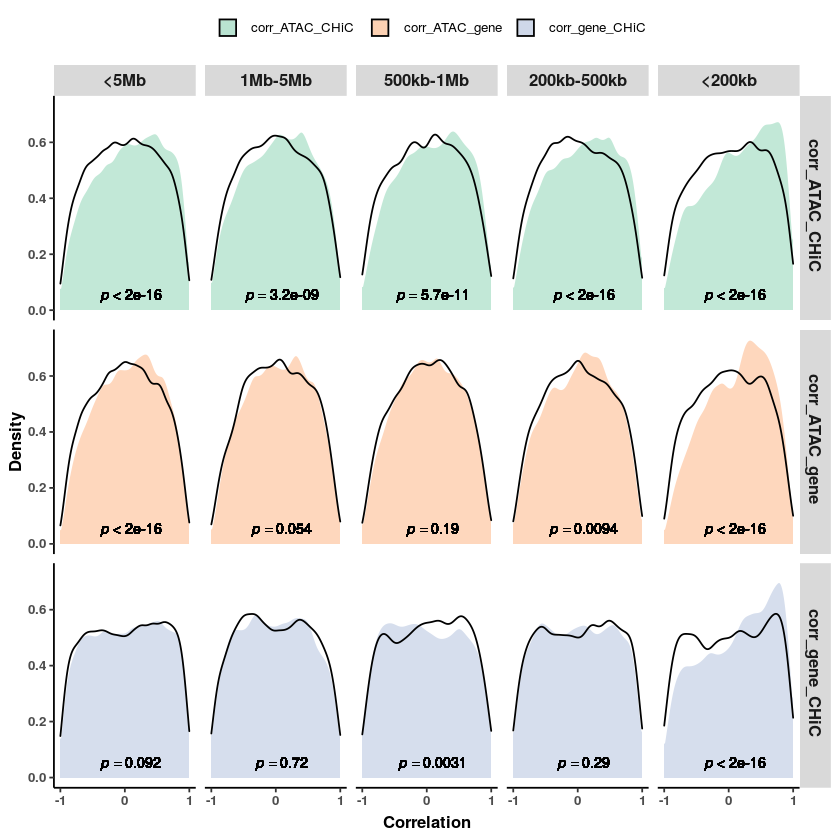

In [30]:
p0 <- ggplot() + geom_density(data=data_forplot , aes(x=correlation, fill=label), color='white', alpha=0.8)  +
geom_density(data=data_forplot2, aes(x=correlation_random), color='black', size=0.5, alpha=0.5) +
geom_text(data=data_forplot, aes(x=0.1,y=0.05, label=label_pvalue), color='black', parse=TRUE, size=3) +

 scale_x_continuous(breaks=c(-1.0,0.0,1.0), labels=c(-1.0,0.0,1.0)) +
#scale_fill_locuszoom() +
scale_fill_brewer(palette="Pastel2") + 
theme(panel.background = element_blank(), plot.title = element_text(face='bold', size=14),
      text=element_text(size=10),
         axis.title=element_text(size=10,face="bold"), axis.text=element_text(size=8,face="bold"), axis.line=element_line('black'),
      ,legend.title=element_blank(), legend.text=element_text(size=8), 
      legend.box.background = element_rect(size=3, color='NA'),
      legend.key.size = unit(0.4, "cm"), legend.spacing.x = unit(0.3, 'cm'),
      strip.text.x=element_text(size=10, face='bold'), strip.text.y=element_text(size=10, face='bold'), legend.position="top") +
 xlab('Correlation') + ylab('Density') + #ggtitle('Fig. 4a') +
facet_grid(label ~ category_f) 
ggsave('~/Dropbox (The University of Manchester)/IntegratingATAC-RNA-HiC/Individual_Figures_Files/CHiC_ATACSeq_gene/correlations_within_ranges_new.png', p0, dpi=600)#+ ggtitle('p value from Wilcox test')
#ggsave(filename='correlation_withinrange.pdf',p0, dpi=300)
p0